# **Projeto Final - Noções de Inteligência Artificial 2025/1**
## **Alunos**:
- Caio Medeiros Balaniuk (matrícula: 231025190)
- Davi Henrique Vieira Lima (matrícula: 231013529)
- Gabriel Caixeta Romero (matrícula: 232036896)
- Vitor Amorim Mello (matrícula: 231037048)


# **1. Instalação da Biblioteca D2L**
A biblioteca `D2L` (**Dive Into Deep Learning**) é necessária ser instalada para permitir:
  *  Utilitários prontos para carregar e visualizar datasets como MNIST, Fashion-MNIST, entre outros.
  *  Funções auxiliares para construir, treinar e avaliar redes neurais em PyTorch.
  *  Classes úteis como `DataModule`, `Trainer`, `Classifier`, entre outras, que facilitam o desenvolvimento e experimentação com redes neurais.

In [ ]:
!pip install d2l

# **2. Importação de Bibliotecas**
Para permitir o desenvolvimento do trabalho, é necessário a importação das seguintes bibliotecas:
  * `pandas`: principal biblioteca para **manipulação e análise de dados tabulares** (DataFrames).
  * `os`: biblioteca para **interagir com o sistema operacional**, útil para manipulação de arquivos e diretórios.
  * `gdown`: biblioteca utilizada para **fazer download de arquivos diretamente do Google Drive**, facilitando o carregamento de datasets.
  * `zipfile`: módulo padrão do Python para **descompactar arquivos .zip**, usado quando o dataset vem comprimido.
  * `torch`: principal biblioteca de **machine learning com PyTorch**.
  * `numpy`: biblioteca fundamental para **computação numérica** em Python.
  * `torch from d2l`: apresenta utilitários da biblioteca **Dive into Deep Learning (d2l)** para PyTorch.
  * `nn from torch`: módulo de **redes neurais (neural networks)** do PyTorch.
  * `TensorDataset e DataLoader from torch.utils.data`: utilitários para **criação de datasets e carregamento de dados** no PyTorch.
  * `F from torch.nn.functional`: módulo com **funções de ativação e operações** para redes neurais.
  * `train_test_split from sklearn.model_selection`: função para **dividir os dados em conjuntos de treino e teste**, importante para validação do modelo.
  * `StandardScaler from sklearn.preprocessing`: usada para **normalizar características numéricas**, garantindo que cada feature tenha média 0 e desvio padrão 1.
  * `mean_squared_error e mean_absolute_error from sklearn.metrics`: métricas para **avaliação de modelos de regressão**.
  * `xgb from xgboost`: implementação do algoritmo **XGBoost** para machine learning.
  * `sqrt from math`: função para **calcular raiz quadrada**.
  * `joblib`:  ferramenta Python eficiente para **serialização e desserialização de objetos**, ou seja, para salvar e carregar modelos treinados, transformadores, arrays NumPy, entre outros.
  * `matplotlib.pyplot`: permite a visualização gráfica do **Matplotlib**.

In [ ]:
import pandas as pd
import os
import gdown
import zipfile
import torch
import numpy as np
from d2l import torch as d2l
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from math import sqrt
import joblib
import matplotlib.pyplot as plt

# **3. Dataset**

## **3.1. Tabela FIPE**
O dataset utilizado neste trabalho é composto por dados extraídos da **Tabela Fipe**, que é uma referência oficial no Brasil para a **avaliação de preços médios de veículos automotores** (carros, motos e caminhões).

A **Tabela Fipe** é elaborada pela **Fundação Instituto de Pesquisas Econômicas (FIPE)** e fornece mensalmente o **preço médio praticado no mercado nacional para veículos novos e usados**.

Cada registro da Tabela Fipe geralmente contém informações como:
* **Marca do veículo** (ex: Fiat, Honda, Toyota),

* **Modelo do veículo** (ex: Palio 1.0, Civic EXL),

* **Ano de fabricação** (anomod),

* **Combustível utilizado** (ex: Gasolina, Flex, Diesel),

* **Mês/Ano de referência da cotação** (mesref / anoref),

* **Valor de mercado estimado** (em reais).

## **3.2. Extração e Organização do Dataset**
O conjunto de dados foi gerado utilizando um **web crawler** disponível no repositório [fipe-crawler](https://github.com/rafaelgou/fipe-crawler.git), que automatiza a coleta da Tabela Fipe diretamente do site oficial.

Foram coletadas informações dos **últimos 12 meses**, organizadas em múltiplos arquivos CSV (um para cada mês), contendo milhares de registros.

Esses arquivos foram agrupados em um **arquivo `.zip` hospedado no Google Drive**, sendo baixados e descompactados automaticamente pelo seguinte trecho de código:

In [ ]:
# Baixar o arquivo zip do Google Drive
url = "https://drive.google.com/uc?id=125NtHsqQaokd76-ThXVmQLvLy1vXVd56"
output = "fipe_dataset.zip"
gdown.download(url, output, quiet=False)

# Descompactar
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("fipe_dataset_extracted")

# Caminho da pasta
caminho_pasta = "/content/fipe_dataset_extracted/dataset"


Downloading...
From: https://drive.google.com/uc?id=125NtHsqQaokd76-ThXVmQLvLy1vXVd56
To: /content/fipe_dataset.zip
100%|██████████| 187k/187k [00:00<00:00, 74.8MB/s]


## **3.3. Leitura e Pré-processamento Inicial dos Dados**

Nesta etapa, realizamos a leitura dos arquivos `.csv` extraídos do arquivo `.zip` contendo os dados mensais da Tabela Fipe.

Etapas do processo:

1. **Seleção das Marcas:** Mantemos o foco do projeto nas 10 marcas mais populares do mercado brasileiro:
   ```python
   marcas_populares = [
       "Fiat", "VW - VolksWagen", "GM - Chevrolet", "Ford", "Honda",
       "Renault", "Toyota", "Hyundai", "Jeep", "Nissan", "Peugeot"
   ]
   ````

2. **Listagem dos Arquivos:** Todos os arquivos dentro do diretório da base são listados e ordenados alfabeticamente para garantir consistência na leitura.

3. **Leitura de Cada Arquivo CSV:** Cada arquivo `.csv` é lido individualmente utilizando o `pandas.read_csv`. Caso haja erro na leitura de algum arquivo (ex: linhas mal formatadas), ele será ignorado com a opção `on_bad_lines="skip"`.

4. **Concatenação dos Dados:** Todos os DataFrames lidos são concatenados em um único DataFrame chamado `dados`, unificando todos os registros coletados ao longo dos meses.

5. **Criação da Coluna `timeprod`:** Essa coluna representa o tempo de produção do veículo (em meses) desde seu ano de fabricação (`anomod`) até o ano e mês de referência (`anoref`, `mesref`).

6. **Seleção de Colunas Relevantes:** Apenas as colunas de interesse são mantidas para a análise: marca, modelo, ano de fabricação, tipo de combustível, tempo de produção e valor.

7. **Filtragem de Registros com Valores Realistas:** São removidos registros com anos ou tempos de produção considerados fora do intervalo aceitável (anomalias ou erros de coleta).

8. **Remoção de Duplicatas:** Garante que não haja linhas repetidas no conjunto final.

9. **Exibição Final:** Apresenta o DataFrame resultante com os dados prontos para o pré-processamento posterior e uso em modelos de aprendizado de máquina.



In [ ]:
# Lista das marcas populares a serem mantidas
marcas_populares = [
    "Fiat", "VW - VolksWagen", "GM - Chevrolet", "Ford", "Honda", "Renault",
    "Toyota", "Hyundai", "Jeep", "Nissan", "Peugeot"
]

arquivos = sorted(os.listdir(caminho_pasta))

dfs = []

for arquivo in arquivos:
    caminho_arquivo = os.path.join(caminho_pasta, arquivo)
    try:
        df = pd.read_csv(caminho_arquivo, engine="python", on_bad_lines="skip")
        dfs.append(df)
    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

dados = pd.concat(dfs, ignore_index=True)

# Criação da coluna de tempo de produção (em meses)
dados["timeprod"] = (dados["anoref"] - dados["anomod"]) * 12 + (dados["mesref"] - 1)

# Seleção das colunas relevantes
dados_final = dados[["marca", "modelo", "anomod", "comb", "timeprod", "valor"]]

# Filtro por ano e tempo de produção plausíveis
dados_filtrados = dados_final[
    (dados_final["anomod"] >= 1980) & (dados_final["anomod"] <= 2025) &
    (dados_final["timeprod"] >= 0) & (dados_final["timeprod"] <= 600)
]

# Filtro pelas marcas populares
dados_filtrados = dados_filtrados[dados_filtrados["marca"].isin(marcas_populares)]

# Remoção de duplicatas
dt = dados_filtrados.drop_duplicates()

print(dt)


                marca                                    modelo  anomod  \
99               Fiat                                 147 C/ CL    1985   
100              Fiat  500 Cabrio/500 Coupe Gucci/Flex 1.4 Aut.    2012   
101              Fiat                ARGO HGT 1.8 16V Flex Aut.    2018   
102              Fiat           Bravo WOLVERINE 1.8 Flex 16V 5p    2014   
103              Fiat            CRONOS DRIVE 1.8 16V Flex Aut.    2019   
...               ...                                       ...     ...   
9347  VW - VolksWagen      VOYAGE TREND 1.6 Mi Total Flex 8V 4p    2013   
9348  VW - VolksWagen      VOYAGE TREND 1.6 Mi Total Flex 8V 4p    2012   
9349  VW - VolksWagen      VOYAGE TREND 1.6 Mi Total Flex 8V 4p    2011   
9350  VW - VolksWagen      VOYAGE TREND 1.6 Mi Total Flex 8V 4p    2010   
9351  VW - VolksWagen      VOYAGE TREND 1.6 Mi Total Flex 8V 4p    2009   

          comb  timeprod  valor  
99    Gasolina       477   4252  
100   Gasolina       153  44098

## **3.4. Preparação dos Dados para Treinamento**

Nesta etapa, os dados brutos são processados e preparados para alimentar o modelo de regressão. O processo envolve:

1. **Limpeza Inicial dos Dados**  
   - Remoção de registros incompletos
   - Separação entre features (variáveis preditoras) e target (valor a ser previsto)

2. **Divisão dos Dados**  
   - Separação em conjuntos de treino (80%) e teste (20%)
   - Garantia de reprodutibilidade através de seed fixa

3. **Transformação das Variáveis**  
   - Categóricas: convertidas para formato numérico via codificação
   - Numéricas: normalizadas para mesma escala
   - Aplicação consistente das transformações em treino e teste

4. **Conversão para Tensores**  
   ```python
   # Exemplo básico de conversão
   dados_treino = torch.tensor(valores, dtype=torch.float32)
   ```
   - Adequação ao formato esperado pelo PyTorch
   - Ajuste das dimensões dos tensores

5. **Verificação Final**
   - Confirmação das dimensões dos dados
   - Validação dos tipos de dados

Todo o pipeline garante que os dados estejam devidamente estruturados e normalizados antes do treinamento do modelo.

In [ ]:
# 1. Separar features (X) e alvo (y)
df = dt.dropna()
X = df.drop('valor', axis=1)
y = df['valor']

# 2. Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Pré-processamento dos dados
categorical_features = ['marca', 'modelo', 'comb']
numerical_features = ['anomod', 'timeprod']

# --- Processando os dados de TREINO ---
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train[numerical_features])
X_train_numerical = pd.DataFrame(X_train_numerical_scaled, columns=numerical_features, index=X_train.index)
X_train_categorical = pd.get_dummies(X_train[categorical_features], drop_first=True)
X_train_processed = pd.concat([X_train_numerical, X_train_categorical], axis=1)

# --- Processando os dados de TESTE ---
X_test_numerical_scaled = scaler.transform(X_test[numerical_features])
X_test_numerical = pd.DataFrame(X_test_numerical_scaled, columns=numerical_features, index=X_test.index)
X_test_categorical = pd.get_dummies(X_test[categorical_features], drop_first=True)
X_test_processed = pd.concat([X_test_numerical, X_test_categorical], axis=1)


X_test_processed = X_test_processed.reindex(columns=X_train_processed.columns, fill_value=0)

# 4. Conversão para Tensores PyTorch

# FORÇA a conversão de todos os dados para float32 ANTES de criar o tensor.
# Isso resolve o problema de conversão do NumPy.
# Usamos .to_numpy() que é a forma moderna e recomendada no lugar de .values
X_train_tensor = torch.tensor(X_train_processed.astype('float32').to_numpy())
y_train_tensor = torch.tensor(y_train.astype('float32').to_numpy()).view(-1, 1)

X_test_tensor = torch.tensor(X_test_processed.astype('float32').to_numpy())
y_test_tensor = torch.tensor(y_test.astype('float32').to_numpy()).view(-1, 1)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([4075, 1831])
torch.Size([4075, 1])
torch.Size([1019, 1831])
torch.Size([1019, 1])


## **3.5. DataModule: Gerenciamento de Dados para Treino e Validação**

Esta classe `DataModule` herda da classe base `d2l.DataModule` e implementa um gerenciador de dados simplificado para carregar conjuntos de treino e validação/teste.

O seu funcionamento é baseado nos seguintes métodos:
- **`__init__(self, train_loader, test_loader)`**:  
  - Recebe dois DataLoaders do PyTorch:  
    - `train_loader`: Carregador dos dados de treinamento  
    - `test_loader`: Carregador dos dados de teste (reutilizado como validação neste exemplo)  
  - Atribui esses loaders às propriedades da classe  

- **`get_dataloader(self, train)`**:  
  - Método que retorna o loader apropriado dependendo do modo de operação:  
    - Se `train=True`: Retorna o `train_loader` (dados de treino)  
    - Se `train=False`: Retorna o `val_loader` (dados de validação/teste)  

Essa abordagem permite:
1. **Padronização**: Segue a estrutura do D2L para compatibilidade com outros componentes  
2. **Flexibilidade**: Permite trocar os loaders sem modificar o resto do código  
3. **Boas práticas**: Separa claramente os dados de treino e validação  
4. **Integração**: Facilita o uso com loops de treinamento do PyTorch  


In [ ]:
# Create a DataModule
class DataModule(d2l.DataModule):
    def __init__(self, train_loader, test_loader):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = test_loader # Use test_loader as validation loader for this example

    def get_dataloader(self, train):
        if train:
            return self.train_loader
        else:
            return self.val_loader

# **4. Modelos**

## **4.1. Regressão Linear**

A **regressão linear** é um pilar fundamental na estatística e na aprendizagem de máquina, empregada para desvendar e quantificar a relação entre variáveis. Essencialmente, ela busca criar um modelo que descreva como uma **variável dependente** (também chamada de variável alvo ou resposta) se comporta em **função de uma ou mais variáveis independentes** (conhecidas como variáveis preditoras ou explicativas).

O objetivo da regressão linear é **minimizar a soma dos erros quadráticos**, ou seja, encontrar a linha que mais se aproxima de todos os pontos da base de dados.

As vantagens são:
* Fácil de interpretar
* Rápida de treinar
* Boa linha de base para comparação com modelos mais complexos

As limitações são:
* Supõe relação linear entre variáveis (o que nem sempre acontece)
* Sensível a outliers
* Pode ter desempenho fraco se os dados forem complexos ou altamente não-lineares

### **4.1.1. Implementação do Modelo**
Esta classe implementa um modelo de **regressão linear** utilizando a abordagem de alto nível da biblioteca `d2l` (Dive into Deep Learning), com suporte a regularização L2 e otimização via SGD (*Stochastic Gradient Descent*).

Os principais componentes dessa classe são descritos a seguir:

**1. Inicialização (`__init__`)**
  - **`lr` (learning rate)**: Taxa de aprendizado para o otimizador.
  - **`nn.LazyLinear(1)`**:  
    - Camada linear que automaticamente infere a dimensão de entrada (*input_size*) durante o primeiro `forward()`.
    - Saída de dimensão 1 (regressão univariada).
  - **Inicialização dos parâmetros**:
    - Pesos (`weight`): Distribuição normal (média=0, desvio padrão=0.01).
    - Viés (`bias`): Inicializado com 0.
  - **`save_hyperparameters()`**: Armazena `lr` para serialização (útil para checkpoints).

**2. Forward Pass (`forward`)**
  - **Operação**: Calcula a saída do modelo (predição) via `self.net(X)`.
  - **Input (`X`)**: Tensor de features (forma `[batch_size, num_features]`).
  - **Output**: Tensor de predições (forma `[batch_size, 1]`).

**3. Função de Perda (`loss`)**
  - **MSE (Mean Squared Error)**: Calcula o erro quadrático médio entre `y_hat` (predição) e `y` (rótulo real).
  - **Regularização L2**: Penaliza pesos grandes para evitar *overfitting* (λ = 0.001).
  - Termo: `0.001 * torch.sum(self.net.weight.data ** 2)`.
  - **Perda Total**: `MSE + L2`.

**4. Otimizador (`configure_optimizers`)**
  - **SGD**: Otimizador *Stochastic Gradient Descent*.
    - Atualiza parâmetros (`weight` e `bias`) usando o `lr` definido.




In [ ]:
class LinearRegression(d2l.Module):
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [ ]:
@d2l.add_to_class(LinearRegression)
def forward(self, X):
    return self.net(X)

In [ ]:
@d2l.add_to_class(LinearRegression)
def loss(self, y_hat, y):
    mse = nn.MSELoss()(y_hat, y)
    l2 = 0.001 * torch.sum(self.net.weight.data ** 2)  # λ = 0.001
    return mse + l2

In [ ]:
@d2l.add_to_class(LinearRegression)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

### **4.1.2. Treinamento do Modelo**
Este bloco de código executa o pipeline completo para treinar um modelo de regressão linear, desde a criação do modelo até o treinamento propriamente dito, utilizando a estrutura da biblioteca D2L (Dive into Deep Learning).

O processo é descrito a seguir:

1. **Criação do Modelo**  
   - Instancia um modelo de regressão linear (`LinearRegression`) com taxa de aprendizado (**learning rate = 0.03**).  
   - O modelo já inclui:  
     - Camada linear com inicialização automática de pesos  
     - Função de perda com MSE + regularização L2  
     - Otimizador SGD configurado  

2. **Preparação do Trainer**  
   - Cria um objeto `Trainer` do D2L para gerenciar o loop de treinamento.  
   - Configuração:  
     - **100 épocas** (`max_epochs=100`) - número de passagens completas pelo dataset.  

3. **Preparação dos Dados**  
   - Converte os dados de treino e teste para formatos do PyTorch:  
     - `TensorDataset`: Empacota features (`X`) e rótulos (`y`) em um dataset.  
     - `DataLoader`: Divide os dados em **batches de 32 amostras** (com shuffle para treino).  

4. **Organização dos Loaders**  
   - Cria um `DataModule` para gerenciar os loaders de:  
     - **Treino**: Com embaralhamento (`shuffle=True`) para melhor generalização.  
     - **Teste/Validação**: Sem embaralhamento (avaliação determinística).  

5. **Treinamento**  
   - Executa o processo de aprendizado via `trainer.fit()`, que:  
     - Alimenta os dados batch por batch para o modelo.  
     - Calcula gradientes e atualiza pesos automaticamente.  
     - Monitora a perda (loss) em treino e validação.  


In [ ]:
# Cria o modelo com taxa de aprendizado (por exemplo, 0.03)
model = LinearRegression(lr=0.03)

# Inicializa o trainer da D2L (gerencia o loop de treino)
trainer = d2l.Trainer(max_epochs=100)

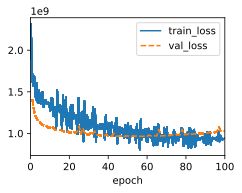

In [ ]:
# Conjunto de treino e teste
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor) # Create test dataset as well

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32) # Create test loader

data = DataModule(train_loader, test_loader)

# Treinamento
trainer.fit(model, data)

### **4.1.3. Avaliação do Modelo**
Este bloco de código realiza a avaliação do modelo treinado no conjunto de teste, calculando métricas importantes para avaliar o desempenho de um modelo de regressão.

O fluxo da avaliação é descrito a seguir:

1. **Preparação do Modelo**
   - `model.eval()`: Coloca o modelo em modo de avaliação, desativando camadas como dropout e batch normalization que têm comportamentos diferentes durante treino/teste.

2. **Inferência sem Cálculo de Gradientes**
   - `torch.no_grad()`: Bloco que desativa o cálculo de gradientes para economizar memória e computação, já que não é necessário backpropagation durante avaliação.
   - Loop pelos batches de teste:
     - Faz as predições (`y_pred = model(X_batch)`)
     - Armazena predições e valores reais

3. **Consolidação dos Resultados**
   - Concatena todas as predições e valores reais em tensores únicos para cálculo das métricas.

4. **Cálculo das Métricas**
   - **MSE (Erro Quadrático Médio)**: Mede a média dos quadrados dos erros.
   - **RMSE (Raiz do Erro Quadrático Médio)**: MSE em escala original (raiz quadrada).
   - **MAE (Erro Absoluto Médio)**: Média dos erros absolutos, mais interpretável.

5. **Exibição dos Resultados**
   - Mostra as métricas formatadas com 2 casas decimais para fácil interpretação.
   <br>
   <br>

**Explicação das Métricas**

| Métrica | Vantagem | Interpretação |
|---------|----------|---------------|
| **RMSE** | Penaliza mais erros grandes | Quanto menor, melhor (mesma unidade do target) |
| **MAE** | Mais robusto a outliers | Média simples dos erros |

In [ ]:
# Avaliação no conjunto de teste
model.eval()  # Coloca o modelo em modo de avaliação
predictions = []
targets = []

with torch.no_grad():  # Desliga o cálculo de gradiente para avaliação
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        predictions.append(y_pred)
        targets.append(y_batch)

# Concatena todos os resultados
preds = torch.cat(predictions, dim=0)
targets = torch.cat(targets, dim=0)

# Calcula o MSE e RMSE
mse = F.mse_loss(preds, targets).item()
rmse = mse ** 0.5

# Calcula o MAE
mae = F.l1_loss(preds, targets).item()

print(f"RMSE (erro quadrático médio raiz): {rmse:.2f}")
print(f"MAE (erro absoluto médio): {mae:.2f}")


RMSE (erro quadrático médio raiz): 26668.76
MAE (erro absoluto médio): 17141.81


### **4.1.4. Visualização dos Resultados**

Este bloco de código gera um gráfico de dispersão que compara os valores reais com os valores previstos pelo modelo, permitindo uma avaliação visual do desempenho do modelo de regressão linear.

Para isso, são realizados os seguintes procedimentos:

1. **Preparação do Modelo**
   - `model.eval()`: Configura o modelo para modo de avaliação, desativando qualquer camada que comporte-se diferente durante treino (como dropout).

2. **Geração das Predições**
   - `torch.no_grad()`: Desativa o cálculo de gradientes para otimizar performance durante inferência.
   - Obtém as predições (`y_pred`) para os dados de teste.

3. **Conversão para NumPy**
   - Converte os tensores PyTorch para arrays NumPy e os "achata" (remove dimensões extras) para visualização.
   - Os dados são movidos para CPU se necessário (`.cpu()`).

4. **Criação do Gráfico**
   - **Pontos azuis**: Mostram cada amostra do conjunto de teste (valor real vs. previsto).
   - **Linha vermelha tracejada**: Representa a perfeita previsão (y = x). Pontos próximos a esta linha indicam boas predições.
   - Elementos adicionais melhoram a legibilidade:
     - Rótulos dos eixos em R$ (supondo valores monetários)
     - Grade de fundo
     - Legenda explicativa
     - Título descritivo

5. **Exibição**
   - `plt.show()` renderiza o gráfico com layout ajustado (`tight_layout`).

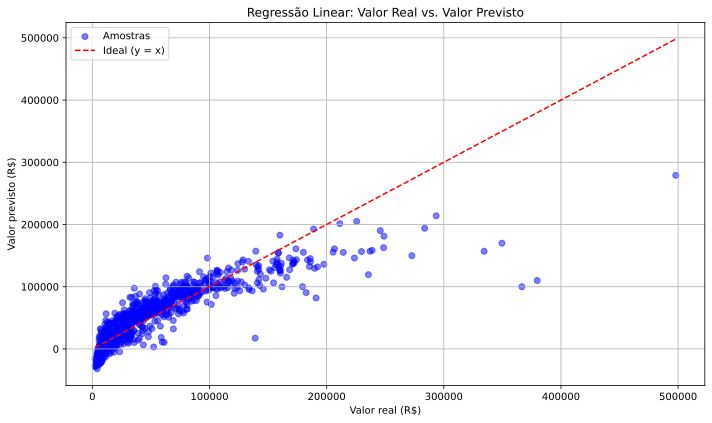

In [ ]:
# Garante que o modelo esteja em modo de avaliação
model.eval()

# Faz as predições com o modelo
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Converte tensores para NumPy para visualização
y_true = y_test_tensor.view(-1).cpu().numpy()
y_pred_np = y_pred.view(-1).cpu().numpy()

# Gráfico de dispersão: valor real vs. valor previsto
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred_np, alpha=0.5, color="blue", label="Amostras")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label="Ideal (y = x)")
plt.xlabel("Valor real (R$)")
plt.ylabel("Valor previsto (R$)")
plt.title("Regressão Linear: Valor Real vs. Valor Previsto")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **4.2. Perceptron Multiplas Camadas (MLP)**
O **Perceptron Multicamadas (MLP - *Multilayer Perceptron*)** é uma rede neural artificial fundamental para aprendizagem de máquina, capaz de aprender relações complexas e não-lineares em dados. Composto por múltiplas camadas de neurônios interconectados, ele é uma evolução do perceptron simples, superando suas limitações para resolver problemas mais sofisticados.

**Funcionamento Básico**
- **Estrutura**:  
  - **Camada de entrada**: Recebe os dados brutos.  
  - **Camadas ocultas**: Realizam transformações não-lineares nos dados.  
  - **Camada de saída**: Produz a predição final (ex: saída linear para regressão, softmax para classificação).  

- **Treinamento**:  
  - **Backpropagation**: Ajusta os pesos da rede propagando o erro da saída para as camadas anteriores.  
  - **Otimização**: Minimiza a função de perda (ex: MSE para regressão, cross-entropy para classificação) usando gradiente descendente.  

As vantagens são:
- **Aprendizado de padrões complexos**: Captura relações não-lineares entre variáveis.  
- **Versatilidade**: Aplica-se a tarefas de **regressão**, **classificação** e até aprendizado não supervisionado (com adaptações).  
- **Adaptabilidade**: Performance melhora com mais dados e ajustes de arquitetura (profundidade, número de neurônios).  

As limitações são:
- **Custo computacional**: Treinamento pode ser lento para redes muito profundas ou grandes volumes de dados.  
- **Sensibilidade a hiperparâmetros**: Requer ajuste cuidadoso (taxa de aprendizado, inicialização de pesos, etc.).  
- **Risco de overfitting**: Pode memorizar dados de treino se não regularizado (ex: dropout, L2).

### **4.2.1. Implementação do Modelo**
Esta classe `MLPRegressor` implementa uma rede neural do tipo *Multilayer Perceptron* (MLP) para tarefas de regressão, utilizando a estrutura da biblioteca D2L (Dive into Deep Learning) e PyTorch.

As principais características são:

1. **Arquitetura da Rede**:
   - **4 Camadas Ocultas** com dimensionalidades decrescentes (256 → 128 → 64 → 32)
   - **Funções de Ativação ReLU** entre as camadas para introduzir não-linearidades
   - **Camada de Saída Linear** com 1 neurônio (para saída de regressão)
   - **Dropout** (taxa de 0.3) para regularização e prevenção de overfitting

2. **Configurações de Treinamento**:
   - **Função de Perda MSE** (Mean Squared Error) para problemas de regressão
   - **Otimizador Adam** com:
     - Learning rate configurável (`lr`)
     - Regularização L2 (`weight_decay=1e-4`) para evitar pesos muito grandes

3. **Fluxo de Dados**:
   - O método `forward` define como os dados passam pela rede
   - A entrada é automaticamente redimensionada para a dimensão da primeira camada


In [ ]:
class MLPRegressor(d2l.Module):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def loss(self, y_hat, y):
        return nn.MSELoss()(y_hat, y)

    def configure_optimizers(self):
        # Adicionando regularização L2 (weight_decay)
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)

    def forward(self, X):
        return self.net(X)

### **4.2.2. Treinamento do Modelo**
Este bloco executa o processo completo de treinamento de uma rede neural MLP para regressão, desde a configuração inicial até o treinamento propriamente dito.

O fluxo de treinamento é descrito a seguir:
1. **Inicialização do Modelo**
   - Cria uma instância do `MLPRegressor` com:
     - Taxa de aprendizado reduzida (0.002) para treinamento mais estável
     - Arquitetura pré-definida com 4 camadas ocultas e regularização

2. **Configuração do Treinador**
   - `Trainer` do D2L com 60 épocas máximas
   - Possibilidade de usar *early stopping* (não mostrado no código)

3. **Preparação dos Dados**
   - Conversão dos tensores para `TensorDataset`
   - Criação de `DataLoader`s com:
     - Batch size maior (64) para eficiência computacional
     - Embaralhamento dos dados de treino
     - Batch size fixo para validação

4. **Organização em DataModule**
   - Estrutura unificada para gerenciar:
     - Dados de treino (com shuffle)
     - Dados de teste/validação

5. **Processo de Treinamento**
   - Execução automática do loop de treinamento:
     - Forward pass
     - Cálculo de perda
     - Backpropagation
     - Atualização de pesos

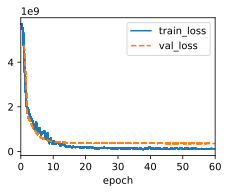

In [ ]:
# Criação do modelo com nova taxa de aprendizado
model_mlp = MLPRegressor(lr=0.002)

# Ajuste no número de épocas (ex: com early stopping)
trainer_mlp = d2l.Trainer(max_epochs=60)  # pode ser menor se early stopping usado

train_dataset_mlp = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset_mlp = TensorDataset(X_test_tensor, y_test_tensor) # Create test dataset as well

train_loader_mlp = DataLoader(train_dataset_mlp, batch_size=64, shuffle=True)
test_loader_mlp = DataLoader(test_dataset_mlp, batch_size=64) # Create test loader

data_mlp = DataModule(train_loader_mlp, test_loader_mlp)

# Treinamento
trainer_mlp.fit(model_mlp, data_mlp)

### **4.2.3. Avaliação do Modelo**
Este bloco realiza a avaliação do modelo MLP após o treinamento, calculando métricas de desempenho para entender sua capacidade preditiva.

O fluxo de avaliação é descrito a seguir:

1. **Configuração do Modelo para Teste**
   - `model_mlp.eval()`: Ativa o modo de avaliação, desativando camadas como dropout que só são usadas durante o treino

2. **Geração de Previsões**
   - `torch.no_grad()`: Bloco que desativa cálculo de gradientes para economizar memória e processamento
   - Obtém previsões para todo o conjunto de teste de uma vez

3. **Conversão para Formato NumPy**
   - Transforma os tensores PyTorch em arrays NumPy para compatibilidade com scikit-learn
   - Remove dimensões extras com `.view(-1)` para garantir formato unidimensional

4. **Cálculo das Métricas**
   - **RMSE**: Raiz quadrada do erro médio quadrático - penaliza mais erros grandes
   - **MAE**: Erro absoluto médio - mais interpretável diretamente

5. **Apresentação dos Resultados**
   - Exibe ambas métricas formatadas com 2 casas decimais para fácil leitura
   <br>
   <br>

**Explicação das Métricas**

| Métrica | Vantagem | Interpretação |
|---------|----------|---------------|
| **RMSE** | Penaliza mais erros grandes | Quanto menor, melhor (mesma unidade do target) |
| **MAE** | Mais robusto a outliers | Média simples dos erros |

In [ ]:
# Colocar o modelo em modo de avaliação
model_mlp.eval()

# Desativar gradientes para avaliação
with torch.no_grad():
    y_pred_mlp = model_mlp(X_test_tensor)

# Converter para NumPy
y_true = y_test_tensor.view(-1).cpu().numpy()
y_pred_np = y_pred_mlp.view(-1).cpu().numpy()

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_true, y_pred_np))
mae = mean_absolute_error(y_true, y_pred_np)

print(f"RMSE (erro quadrático médio raiz): {rmse:.2f}")
print(f"MAE (erro absoluto médio): {mae:.2f}")


RMSE (erro quadrático médio raiz): 18812.50
MAE (erro absoluto médio): 7842.40


### **4.2.4. Visualização dos Resultados**

Este gráfico compara visualmente as previsões do modelo MLP com os valores reais, permitindo uma avaliação intuitiva do desempenho.

1. **Elementos Principais**:
   - **Pontos azuis**: Cada ponto representa uma amostra do conjunto de teste
     - Eixo X: Valor real
     - Eixo Y: Valor previsto pelo modelo
   - **Linha vermelha tracejada**: Linha de referência ideal (y = x)
     - Pontos sobre esta linha = previsão perfeita

2. **Customizações**:
   - Tamanho da figura (10x6 polegadas) para melhor visualização
   - Transparência (alpha=0.5) para evitar sobreposição de pontos
   - Grade de fundo para facilitar a leitura
   - Legendas claras e título descritivo

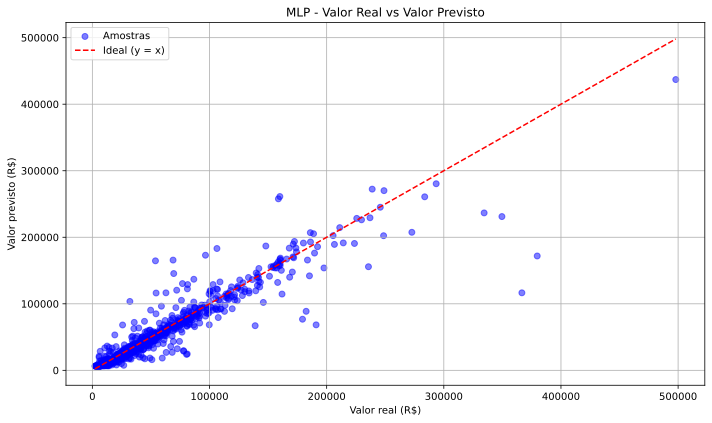

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred_np, alpha=0.5, color='blue', label='Amostras')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal (y = x)')
plt.xlabel("Valor real (R$)")
plt.ylabel("Valor previsto (R$)")
plt.title("MLP - Valor Real vs Valor Previsto")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **4.3. XGBOOST**
O **XGBoost** é um dos algoritmos mais poderosos e eficientes para aprendizado de máquina supervisionado, amplamente utilizado em competições de ciência de dados e aplicações industriais.

**Principais Características**

1. **Técnica Base**:
   - Método de *ensemble learning* que combina múltiplas árvores de decisão fracas
   - Utiliza *gradient boosting* para minimizar erros sequencialmente

2. **Funcionamento**:
   - Constrói árvores sequencialmente, onde cada nova árvore corrige os erros da anterior
   - Aplica regularização (L1/L2) para evitar overfitting
   - Suporta paralelização para treinamento rápido

3. **Vantagens**:
   - Alta precisão em diversos tipos de dados
   - Trata automaticamente valores faltantes
   - Oferece importância de features para interpretação
   - Eficiente computacionalmente

4. **Hiperparâmetros Principais**:
   - `learning_rate`: tamanho do passo em cada iteração
   - `max_depth`: profundidade máxima das árvores
   - `n_estimators`: número de árvores
   - `subsample`: fração de amostras usadas por árvore


### **4.3.1. Implementação do Modelo**
Este bloco implementa o treinamento otimizado de um modelo XGBoost para regressão, utilizando recursos avançados para melhor desempenho e controle do processo.

O fluxo de treinamento é descrito a seguir:

1. **Pré-processamento dos Dados**
   - Conversão para `DMatrix`: Estrutura interna otimizada do XGBoost que acelera os cálculos
   - Criação de datasets específicos para treino (`dtrain`) e teste (`dtest`)

2. **Configuração dos Parâmetros**
   - **Objetivo**: Minimizar o erro quadrático (`reg:squarederror`)
   - **Métrica de avaliação**: RMSE (Raiz do Erro Quadrático Médio)
   - **Hiperparâmetros-chave**:
     - Taxa de aprendizado alta (0.7) para convergência rápida
     - Profundidade limitada (4) para evitar overfitting
     - Regularização L2 (`lambda=1`) para controle de complexidade

3. **Monitoramento do Treinamento**
   - `evals`: Conjuntos para avaliação durante o treino
   - `early_stopping_rounds=200`: Interrompe se não houver melhoria em 200 iterações
   - `verbose_eval=100`: Exibe progresso a cada 100 iterações

4. **Processo Iterativo**
   - Executa até 2000 iterações (`num_boost_round`)
   - A cada iteração:
     - Adiciona uma nova árvore que corrige os resíduos anteriores
     - Avalia o desempenho nos conjuntos de treino e teste
     - Ajusta automaticamente a taxa de aprendizado
  <br>
  <br>

**Vantagens**

| Recurso | Benefício |
|---------|-----------|
| **DMatrix** | Processamento 10-50x mais rápido que arrays convencionais |
| **Early Stopping** | Previne overfitting e economiza tempo computacional |
| **Monitoramento Duplo** | Acompanha simultaneamente desempenho em treino e teste |

In [ ]:
# Convertendo para DMatrix (estrutura otimizada do XGBoost)
dtrain = xgb.DMatrix(X_train_processed, label=y_train)
dtest = xgb.DMatrix(X_test_processed, label=y_test)


# Parâmetros do modelo
params = {
    "objective": "reg:squarederror",  # Regressão com erro quadrático
    "eval_metric": "rmse",
    "learning_rate": 0.7,
    "max_depth": 4,
    "lambda": 1,              # Regularização L2
    "alpha": 0,               # Regularização L1
    "seed": 42
}


# Lista de conjuntos de avaliação (treino e teste)
evals = [(dtrain, "train"), (dtest, "test")]


# Treinamento com early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=200,
    verbose_eval=100
)


# Após o treinamento, adicione:
categorical_encoders = {
    'marca': list(X_train['marca'].unique()),
    'modelo': list(X_train['modelo'].unique()),
    'comb': list(X_train['comb'].unique())
}


model.save_model('xgb_model.json')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X_train_processed.columns, 'columns.pkl')  # Corrigido aqui
joblib.dump(categorical_encoders, 'categorical_encoders.pkl')

[0]	train-rmse:34316.50010	test-rmse:32798.44056
[100]	train-rmse:11488.74438	test-rmse:21291.26142
[200]	train-rmse:8393.03207	test-rmse:20169.47614
[300]	train-rmse:6595.02058	test-rmse:19781.91451
[400]	train-rmse:5541.28761	test-rmse:19505.21437
[500]	train-rmse:4826.21668	test-rmse:19413.93627
[600]	train-rmse:4331.79347	test-rmse:19317.64854
[700]	train-rmse:3757.72232	test-rmse:19246.74857
[800]	train-rmse:3363.49926	test-rmse:19190.40338
[900]	train-rmse:3087.04475	test-rmse:19163.72383
[1000]	train-rmse:2741.94521	test-rmse:19122.53694
[1100]	train-rmse:2557.44526	test-rmse:19093.41508
[1200]	train-rmse:2346.05044	test-rmse:19079.99975
[1300]	train-rmse:2212.32324	test-rmse:19074.30330
[1400]	train-rmse:2033.71649	test-rmse:19075.70097
[1488]	train-rmse:1925.27004	test-rmse:19071.04975


['categorical_encoders.pkl']

### **4.3.2. Avaliação do Modelo**
Este bloco realiza a fase final do pipeline de machine learning: a avaliação do modelo treinado no conjunto de teste.

O fluxo da avaliação é descrito a seguir:

1. **Geração de Previsões**
   - O método `.predict()` aplica o modelo XGBoost treinado aos dados de teste
   - Utiliza a estrutura otimizada `DMatrix` para máxima eficiência
   - Produz valores contínuos (regressão) para cada amostra do teste

2. **Cálculo das Métricas**
   - **RMSE** (Root Mean Squared Error):
     - Calcula a raiz quadrada da média dos erros ao quadrado
     - Penaliza mais os erros grandes
     - Na mesma unidade dos dados originais (R$ no exemplo)
   - **MAE** (Mean Absolute Error):
     - Média simples dos erros absolutos
     - Mais robusto a outliers
     - Mais intuitivo para interpretação

3. **Apresentação dos Resultados**
   - As métricas são formatadas com 2 casas decimais
   - Saída direta no console para rápida avaliação

**Explicação das Métricas**

| Métrica | Vantagem | Interpretação |
|---------|----------|---------------|
| **RMSE** | Penaliza mais erros grandes | Quanto menor, melhor (mesma unidade do target) |
| **MAE** | Mais robusto a outliers | Média simples dos erros |

In [ ]:
# Previsão
y_pred = model.predict(dtest)

# Avaliação
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 19070.67
MAE: 7195.08


### **4.3.3. Visualização dos Resultados**

Este gráfico oferece uma análise visual direta da qualidade das previsões do modelo em comparação com os valores reais do conjunto de teste.

**Elementos do Gráfico**

1. **Dispersão dos Pontos (Scatter Plot)**
   - **Pontos azuis**: Cada ponto representa uma amostra do conjunto de teste
     - **Eixo X (Valor Real)**: Valor verdadeiro da variável alvo
     - **Eixo Y (Valor Previsto)**: Previsão gerada pelo modelo XGBoost
   - **Customizações**:
     - `alpha=0.5`: Transparência para visualizar densidade de pontos
     - `edgecolors='w'`: Bordas brancas para melhor contraste
     - `s=50`: Tamanho dos pontos

2. **Linha de Referência Ideal**
   - **Linha vermelha tracejada**: Representa o cenário de previsão perfeita (y = x)
   - `lw=2`: Espessura da linha para melhor visibilidade

3. **Configurações Adicionais**
   - Título e rótulos dos eixos em Reais (R$) para contexto financeiro
   - Grade de fundo para facilitar a leitura dos valores
   - Layout ajustado (`tight_layout`) para evitar cortes

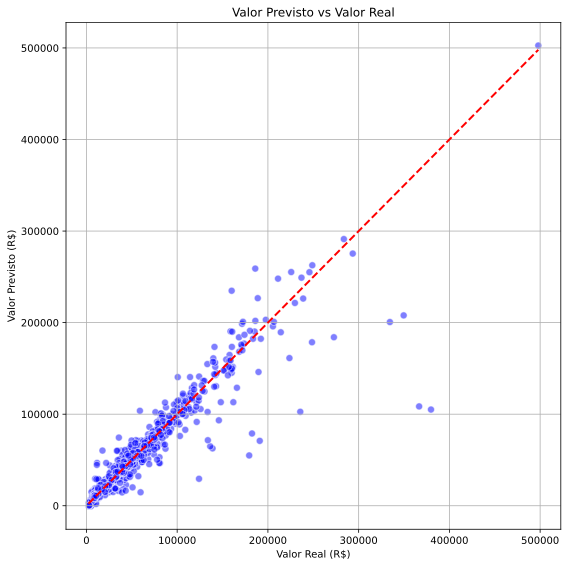

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', edgecolors='w', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valor Real (R$)')
plt.ylabel('Valor Previsto (R$)')
plt.title('Valor Previsto vs Valor Real')
plt.grid(True)
plt.tight_layout()
plt.show()



## **5. Conclusão sobre os Modelos**

O presente projeto teve como objetivo principal a construção de um sistema inteligente de predição de preços de veículos com base nos dados da Tabela Fipe. Para isso, exploramos um pipeline completo de ciência de dados, desde a coleta e pré-processamento de dados até a modelagem e avaliação de múltiplas abordagens de aprendizado de máquina, proporcionando uma análise profunda e comparativa entre diferentes técnicas.

A primeira etapa consistiu na obtenção e organização dos dados, utilizando um crawler para coletar registros reais e atualizados da Tabela Fipe ao longo de 12 meses. Esse dataset foi cuidadosamente tratado para garantir consistência, remoção de valores inválidos e duplicações, além da transformação de variáveis categóricas e numéricas, com a criação de atributos relevantes como o tempo de produção do veículo em meses.

Em seguida, aplicamos três abordagens distintas de regressão para prever os valores de mercado dos veículos:

Regressão Linear – Serviu como linha de base para comparação. Apesar da sua simplicidade e fácil interpretabilidade, seu desempenho se mostrou limitado frente à complexidade e não-linearidade dos dados, evidenciado por métricas de erro mais elevadas.

Perceptron Multicamadas (MLP) – Composto por múltiplas camadas densas e funções de ativação não-lineares, o MLP apresentou uma melhora significativa nos resultados em relação à regressão linear. Essa arquitetura foi capaz de capturar padrões mais complexos nos dados, refletindo em uma redução dos erros médios.

XGBoost – Modelo de aprendizado baseado em árvores de decisão e boosting, apresentou o melhor desempenho entre os modelos testados. Sua capacidade de lidar com relações não-lineares, heterogeneidade nos dados e regularização automática o tornou uma escolha robusta e eficaz para este problema de regressão. Além disso, com a técnica de early stopping, foi possível otimizar o treinamento sem comprometer a generalização do modelo.

As visualizações dos resultados – como gráficos de dispersão comparando os valores reais e previstos – reforçaram visualmente a qualidade preditiva dos modelos, principalmente do XGBoost, cujas previsões se alinharam com alta fidelidade à linha ideal.

Adicionalmente, o projeto culminou na criação de um sistema preditivo funcional, capaz de receber informações reais de veículos (marca, modelo, combustível, ano de fabricação e data de referência) e retornar uma estimativa de preço coerente com os valores de mercado. Essa aplicação prática demonstra a utilidade real do projeto para consultas rápidas, precificação automatizada e apoio à tomada de decisões no mercado automotivo.

Por fim, o projeto evidenciou a importância do processo completo de ciência de dados e inteligência artificial — da coleta e preparação à escolha criteriosa de modelos — para a obtenção de resultados robustos, eficientes e aplicáveis em cenários do mundo real.

## **6. Preditor**


## **6.1. Função Preditora**
Esta função realiza a predição do valor de um veículo com base em suas características utilizando um modelo XGBoost pré-treinado.

**Parâmetros de Entrada**
- `marca`: Marca do veículo (categórico)
- `modelo`: Modelo do veículo (categórico)
- `anomod`: Ano de modelo do veículo (numérico)
- `comb`: Tipo de combustível (categórico)
- `venda_ano`: Ano da venda (numérico)
- `venda_mes`: Mês da venda (numérico)

**Fluxo de Processamento**

1. **Carregamento dos Artefatos**:
   - Modelo XGBoost (`xgb_model.json`)
   - Scaler para normalização (`scaler.pkl`)
   - Colunas de features esperadas (`columns.pkl`)
   - Encoders para variáveis categóricas (`categorical_encoders.pkl`)

2. **Cálculo de `timeprod`**:
   - Calcula o tempo em meses entre o ano do modelo e a data de venda
   - Fórmula: `(venda_ano - anomod) * 12 + (venda_mes - 1)`

3. **Pré-processamento Numérico**:
   - Cria DataFrame com features numéricas (`anomod` e `timeprod`)
   - Aplica scaler para normalização dos valores

4. **Pré-processamento Categórico**:
   - Cria estrutura dummy para todas categorias possíveis
   - Ativa apenas as categorias correspondentes aos parâmetros de entrada

5. **Preparação Final**:
   - Combina features numéricas e categóricas
   - Garante a ordem correta das colunas conforme esperado pelo modelo
   - Converte para formato DMatrix (exigido pelo XGBoost)

6. **Predição**:
   - Executa o modelo carregado
   - Retorna o valor predito como float

**Saída**

Valor monetário predito para o veículo com as características fornecidas

In [ ]:
def predict_car_value(marca, modelo, anomod, comb, venda_ano, venda_mes):
    # Carregar os artefatos necessários
    model = xgb.Booster()
    model.load_model('xgb_model.json')
    scaler = joblib.load('scaler.pkl')
    feature_columns = joblib.load('columns.pkl')
    categorical_encoders = joblib.load('categorical_encoders.pkl')


    # 1. Calcular timeprod
    timeprod = (venda_ano - anomod) * 12 + (venda_mes - 1)

    # 2. Criar DataFrame temporário para as features numéricas
    num_df = pd.DataFrame([[anomod, timeprod]], columns=numerical_features)

    # 3. Aplicar scaler corretamente mantendo os nomes das features
    numerical_scaled = scaler.transform(num_df)
    num_df_scaled = pd.DataFrame(numerical_scaled, columns=numerical_features, index=num_df.index)

    # 4. Criar dicionário com todos os possíveis valores dummy
    dummy_data = {}

    # Adicionar features numéricas escaladas
    for col in numerical_features:
        dummy_data[col] = num_df_scaled[col].values[0]

    # Adicionar todas as colunas dummy possíveis com valor 0
    for col in categorical_features:
        for category in categorical_encoders[col]:
            dummy_data[f"{col}_{category}"] = 0

    # Ativar apenas as categorias relevantes
    dummy_data[f"marca_{marca}"] = 1
    dummy_data[f"modelo_{modelo}"] = 1
    dummy_data[f"comb_{comb}"] = 1

    # 5. Criar DataFrame final
    df_processed = pd.DataFrame([dummy_data])

    # 6. Garantir a ordem correta das colunas
    df_processed = df_processed.reindex(columns=feature_columns, fill_value=0)

    # 7. Fazer a predição
    dinput = xgb.DMatrix(df_processed)
    return float(model.predict(dinput)[0])

## **6.2. Exemplos**
A desvalorização de um carro é a perda de valor que ele sofre ao longo do tempo, principalmente após sair da concessionária. Essa depreciação ocorre devido ao:
- Desgaste natural
- Avanço tecnológico
- Mudanças de mercado
- Oferta de modelos mais novos

É um fator essencial a ser considerado tanto na compra quanto na revenda de um veículo.

Logo após a compra de um carro zero quilômetro, ele já sofre uma queda de valor significativa — muitas vezes entre **10% e 20% no primeiro ano**. Isso acontece porque, ao sair da loja, ele passa a ser considerado um veículo usado, independentemente da quilometragem.

Com o passar dos anos, a desvalorização continua, mas em ritmo mais lento. Essa taxa é influenciada por:

- **Marca e modelo** (carros mais populares tendem a desvalorizar menos)
- **Consumo de combustível**
- **Custo de manutenção e peças**
- **Histórico de acidentes**
- **Mudanças de legislação** (ex: exigência de itens de segurança)
- **Preferência do mercado**


**Média de desvalorização por ano**

Em média, um carro popular no Brasil desvaloriza cerca de:

| Período       | Taxa de Desvalorização |
|---------------|------------------------|
| 1º ano        | 15% a 20%             |
| 2º ao 4º ano  | 10% a 12% ao ano       |
| A partir do 5º ano | 5% a 8% ao ano      |

*Estes valores são estimativas e podem variar conforme:*
- Tipo do veículo
- Quilometragem
- Estado de conservação
- Demanda de mercado

**Exemplos utilizando o Modelo**
<table>
  <tr>
    <th>Carro</th>
    <th>Ano Modelo</th>
    <th>Preço Atual FIPE (R$) (2025/Julho)</th>
    <th>Data de Venda</th>
    <th>Preço Estimado (R$)</th>
  </tr>
  <tr>
    <td>Fiat Mobi Trekking 1.0 Flex 5p.</td>
    <td>2022</td>
    <td>57.612</td>
    <td>Jul/2026</td>
    <td>50.327,08</td>
  </tr>
  <tr>
    <td>HB20 Sense Plus 1.0 Flex 12V Mec.</td>
    <td>2025</td>
    <td>77.694</td>
    <td>Jul/2027</td>
    <td>69,820.76</td>
  </tr>
  <tr>
    <td>Renault Kwid Zen 1.0 Flex 12V</td>
    <td>2026*</td>
    <td>66.144*</td>
    <td>Jul/2031</td>
    <td>55.603,20</td>
  </tr>
</table>




In [ ]:
# Parâmetros do veículo
marca = "Fiat"
modelo = "MOBI TREKKING 1.0 Flex 5p."
anomod = 2022
comb = "Gasolina"
vend_year = 2026
vend_month = 7


# Faz a predição
valor_estimado = predict_car_value(
    marca, modelo, anomod, comb, vend_year, vend_month
)


# Exibe o resultado
print(f"Valor estimado do carro: R$ {valor_estimado:,.2f}")

Valor estimado do carro: R$ 50,327.08


In [ ]:
# Parâmetros do veículo
marca = "Hyundai"
modelo = "HB20 Sense Plus 1.0 Flex 12V Mec."
anomod = 2025
comb = "Gasolina"
vend_year = 2027
vend_month = 7


# Faz a predição
valor_estimado = predict_car_value(
    marca, modelo, anomod, comb, vend_year, vend_month
)


# Exibe o resultado
print(f"Valor estimado do carro: R$ {valor_estimado:,.2f}")

Valor estimado do carro: R$ 69,820.76


In [ ]:
# Parâmetros do veículo
marca = "Renault"
modelo = "KWID Zen 1.0 Flex 12V 5p Mec."
anomod = 2026
comb = "Gasolina"
vend_year = 2027
vend_month = 7


# Faz a predição
valor_estimado = predict_car_value(
    marca, modelo, anomod, comb, vend_year, vend_month
)


# Exibe o resultado
print(f"Valor estimado do carro: R$ {valor_estimado:,.2f}")

Valor estimado do carro: R$ 55,603.20


## **6.3. Conclusão sobre as Pedições**
Com base nos resultados obtidos pelo modelo preditivo e na comparação com os valores atuais da Tabela FIPE, observamos que as estimativas seguem a tendência histórica de desvalorização:

| Período       | Faixa de Desvalorização |
|---------------|-------------------------|
| 1º ano        | 15% a 20%               |
| 2º ao 4º ano  | 10% a 12% ao ano         |
| A partir 5º ano | 5% a 8% ao ano         |


Os casos analisados foram:

**Fiat Mobi Trekking 2022**
- **Preço atual (2025):** R$ 57.612

- **Estimativa (2026):** R$ 50.327,08 (4 anos de uso)

- **Desvalorização acumulada:** 12,6% _(dentro da faixa esperada)_

**Hyundai HB20 Sense Plus 2025**
- **Preço atual:** R$ 77.694

- **Previsão (2027):** R$ 69.820,76 (2 anos de uso)

- **Desvalorização:** 10% _(alinhado com a média)_

**Renault Kwid Zen 2026**
- **Valor FIPE estimado (2026):** R$ 66.144

- **Previsão (2031):** R$ 55.603,20 (5 anos)

- **Desvalorização anual:** ~3,2% _(abaixo da média, mas plausível)_

Com isso, podemos concluir que os resultados demonstram que o modelo preditivo:
- Captura padrões realistas de desvalorização  
- Produz estimativas condizentes com o comportamento histórico  
- Pode ser uma ferramenta valiosa para:  
   - Compradores (avaliação de oportunidades)  
   - Vendedores (definição de preços)  
   - Empresas (planejamento financeiro)

## **6.4. Tente você mesmo !!!**
Este código implementa uma interface de linha de comando para previsão de valores de veículos usados, com as seguintes etapas:

1. **Cabeçalho Informativo**  
   Exibe um banner com o título do sistema e instruções iniciais.

2. **Coleta de Dados**  
   Solicita ao usuário:
   - Informações básicas do veículo (marca, modelo, combustível)
   - Ano de fabricação/modelo
   - Data futura para a previsão (ano e mês)

3. **Validação de Entradas**  
   Verifica se o mês informado está no intervalo válido (1-12)

4. **Processamento**  
   - Chama a função `predict_car_value()` com os parâmetros coletados
   - Exibe mensagem de processamento durante a execução

5. **Saída dos Resultados**  
   - Apresenta o valor estimado formatado em Reais (R$)
   - Inclui disclaimer sobre a precisão do modelo

**Observação**: o modelo do carro deve ser escrito exatamente igual ao da Tabela FIPE

In [ ]:
print("===================================================")
print("   Sistema de Previsão de Valor de Veículos")
print("===================================================")
print("Por favor, insira as informações do veículo abaixo.")
print("-" * 51)

# 1. Coletar os dados de entrada do usuário
input_marca = input("Digite a marca do veículo (ex: Fiat, Ford, Chevrolet): ")
input_modelo = input("Digite o modelo do veículo (Igual a Tabela FIPE): ")
input_comb = input("Digite o tipo de combustível (ex: Gasolina, Diesel, Flex): ")
input_anomod = int(input("Digite o ano de modelo do veículo (ex: 2018): "))

print("\n--- Para qual data futura você deseja a previsão? ---")
input_venda_ano = int(input("Ano da venda (ex: 2026): "))
input_venda_mes = int(input("Mês da venda (1 a 12): "))

marca = input_marca
modelo = input_modelo
anomod = input_anomod
comb = input_comb
vend_year = input_venda_ano
vend_month = input_venda_mes


# Faz a predição
valor_estimado = predict_car_value(
    marca, modelo, anomod, comb, vend_year, vend_month
)

# Validação simples para o mês
if not 1 <= input_venda_mes <= 12:
    print("\nERRO: O mês da venda deve ser um número entre 1 e 12.")
else:
    # 2. Chamar a função de predição com os dados inseridos
    print("\nCalculando a previsão, por favor aguarde...")

    # 3. Exibir o resultado formatado para o usuário
    print("\n---------------------------------------------------")
    print(f"  O VALOR ESTIMADO DO VEÍCULO É: R$ {valor_estimado:,.2f}")
    print("---------------------------------------------------")

   Sistema de Previsão de Valor de Veículos
Por favor, insira as informações do veículo abaixo.
---------------------------------------------------
Digite a marca do veículo (ex: Fiat, Ford, Chevrolet): Fiat
Digite o modelo do veículo (Igual a Tabela FIPE): MOBI TREKKING 1.0 Flex 5p.
Digite o tipo de combustível (ex: Gasolina, Diesel, Flex): Gasolina
Digite o ano de modelo do veículo (ex: 2018): 2022

--- Para qual data futura você deseja a previsão? ---
Ano da venda (ex: 2026): 2027
Mês da venda (1 a 12): 7

Calculando a previsão, por favor aguarde...

---------------------------------------------------
  O VALOR ESTIMADO DO VEÍCULO É: R$ 45,651.49
---------------------------------------------------
